In [ ]:
import os
try:
    from google.colab import drive
    COLAB = True
    print("Estoy en Google CoLab")
    %tensorflow_version 2.x
    !pip install livelossplot
except:
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    print("No estoy en Google CoLab")
    COLAB = False

In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers as l
from livelossplot import PlotLossesKerasTF
import pathlib
import os

# Detección de mascarillas con CNN

Vamos a definir algunos parámetros genéricos:

In [2]:
IMAGE_SIZE = (128, 128)

Lectura del conjunto de datos:

In [3]:

data_path = keras.utils.get_file(
    "mask_dataset.zip",
    "https://hdvirtual.us.es/discovirt/index.php/s/dijNRMPYfybYd3N/download",
    extract=True,
    archive_format='zip'
)

DATA_FOLDER = pathlib.Path(data_path).parent / 'mask_ds' 


171245568/171243386 [==============================] - 8s 0us/step


Nos creamos unos generadores de datos para entrenar nuestra red. Vamos a aplicar expansión de datos:

In [4]:
img_gen =tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = img_gen.flow_from_directory(
        os.path.join(DATA_FOLDER, 'train'), 
        target_size=IMAGE_SIZE,
        batch_size=32)

Found 5286 images belonging to 2 classes.


In [5]:
img_gen =tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_generator = img_gen.flow_from_directory(
        os.path.join(DATA_FOLDER, 'validation'), 
        target_size=IMAGE_SIZE,
        batch_size=32)

Found 2267 images belonging to 2 classes.


Mostramos una de las muestras:

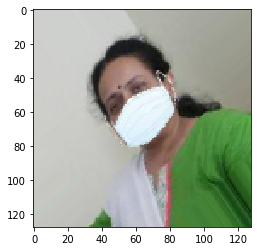

In [6]:
from matplotlib import pyplot as plt
plt.imshow(train_generator.__getitem__(0)[0][2])

In [7]:
train_generator.__getitem__(0)[1][2]

array([1., 0.], dtype=float32)

In [8]:
model = tf.keras.models.Sequential()

model.add(l.Input((IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(l.Conv2D(32, (3,3), padding='same'))
model.add(l.Activation("relu"))
model.add(l.Conv2D(32, (3,3), padding='same'))
model.add(l.Activation("relu"))
model.add(l.MaxPooling2D())
model.add(l.Conv2D(32, (3,3), padding='same'))
model.add(l.Activation("relu"))
model.add(l.Conv2D(32, (3,3), padding='same'))
model.add(l.Activation("relu"))
model.add(l.MaxPooling2D())
model.add(l.Conv2D(32, (3,3), padding='same'))
model.add(l.Activation("relu"))
model.add(l.Conv2D(32, (3,3), padding='same'))
model.add(l.Activation("relu"))
model.add(l.MaxPooling2D())
model.add(l.Conv2D(32, (3,3), padding='same'))
model.add(l.Activation("relu"))
model.add(l.Conv2D(32, (3,3), padding='same'))
model.add(l.Activation("relu"))
model.add(l.Conv2D(32, (3,3), padding='same'))
model.add(l.Activation("relu"))
model.add(l.MaxPooling2D())
model.add(l.Flatten())
model.add(l.Dense(1024))
model.add(l.Activation("relu"))
model.add(l.Dense(1024))
model.add(l.Activation("relu"))
model.add(l.Dense(30))
model.add(l.Activation("relu"))
model.add(l.Dense(2))
model.add(l.Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0

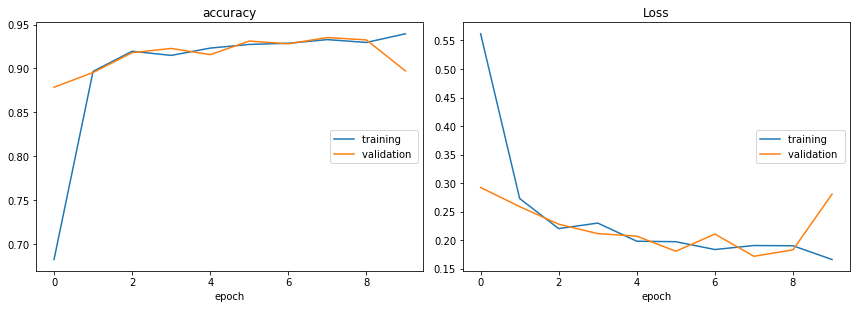

accuracy
	training         	 (min:    0.507, max:    0.939, cur:    0.939)
	validation       	 (min:    0.507, max:    0.935, cur:    0.897)
Loss
	training         	 (min:    0.166, max:    0.694, cur:    0.166)
	validation       	 (min:    0.172, max:    0.694, cur:    0.281)
166/166 [==============================] - 36s 214ms/step - loss: 0.1661 - accuracy: 0.9395 - val_loss: 0.2806 - val_accuracy: 0.8972


In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_generator, 
          validation_data=val_generator,
          epochs=10, 
          batch_size=32, 
          steps_per_epoch=len(train_generator),
          validation_steps=len(val_generator),
          callbacks=[PlotLossesKerasTF()])

Podemos guardar nuestro modelo con el método save:

In [9]:
model.save('mask.h5')

El siguiente código nos va a pertimir acceder a la cámara del equipo. En la variable *image* se guardará el último frame tomado de la camara

In [75]:
from IPython.display import HTML, display, update_display

main_text = """
<video id="video" width="320" height="240" autoplay style="display:none"></video>
<canvas id="canvas" width="320" height="240"  ></canvas>

<script>
// Grab elements, create settings, etc.
var video = document.getElementById('video');

// Get access to the camera!
if(navigator.mediaDevices && navigator.mediaDevices.getUserMedia) {
    // Not adding `{ audio: true }` since we only want video now
    navigator.mediaDevices.getUserMedia({ video: true }).then(function(stream) {
        //video.src = window.URL.createObjectURL(stream);
        //video.play();
        video.srcObject=stream;
        video.play();
    });
}

// Elements for taking the snapshot
var canvas = document.getElementById('canvas');
var context = canvas.getContext('2d');
var video = document.getElementById('video');


// Trigger photo take

setInterval(function() {
    context.drawImage(video, 0, 0, 320, 240);
    var myCanvas = document.getElementById('canvas');
    var image = myCanvas.toDataURL("image/png");
    IPython.notebook.kernel.execute("image = '" + image + "'")
    
}, 200);

</script>

"""
HTML(main_text)

Ahora podemos probar si nuestra red ha aprendido a detectar la mascarilla:

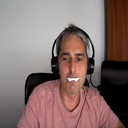

In [46]:
from PIL import Image
import base64
from numpy import asarray
import io
import numpy as np
import time


pil_im = Image.open(io.BytesIO(base64.b64decode(image.split(',')[1])))
pil_im = pil_im.convert('RGB')
pil_im = pil_im.resize(IMAGE_SIZE, Image.ANTIALIAS)
pil_im

In [47]:
im = np.asarray(pil_im) / 255
print(model.predict(np.array([im])).argmax())
result = 'con mascarilla' if model.predict(np.array([im])).argmax() == 0 else 'sin mascarilla'
print(result)

1
sin mascarilla
